In [165]:
global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [166]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

In [167]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

In [168]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [169]:
spacename = input('spacename plz?')
# based on their url, for example "curve.eth" for  https://snapshot.org/#/curve.eth
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)

In [170]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores,
    proposals.scores_total
])

In [171]:
proposals_choices = sg.query(proposals.choices)

In [172]:
proposals_choices = pd.DataFrame(proposals_choices)

In [173]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [174]:
##let's view the output just to make sure
olympus_governance_view.head(5)

,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
0,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,The forum signaling vote hasn't reached the qu...,34450.283619,588045.690668,Original BIP 94,Keep current schedule,Discontinue emissions,None,None,...,None,None,None,None,None,None,None,None,None,None
1,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,The forum signaling vote hasn't reached the qu...,553595.407049,588045.690668,For,Against,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,The forum signaling vote hasn't reached the qu...,0.000000,588045.690668,"Yes, implement changes","No, keep DIGG as is",None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,BIP 93 - Council 2.0,0x73f8baa4de0387402f8c8b092e579379d705a7441f5d...,[BIP 86](https://forum.badger.finance/t/bip-86...,79951.422834,79961.719388,Yes - Confirm Treasury Policy,No - Do Not Confirm,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,BIP 93 - Council 2.0,0x73f8baa4de0387402f8c8b092e579379d705a7441f5d...,[BIP 86](https://forum.badger.finance/t/bip-86...,10.296554,79961.719388,"Yes, implement the new boost","No, boost is good as is",None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [175]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean.head(10)

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores,proposals_scores_total,0,1,2,3,...,6,7,8,9,10,11,12,13,14,15
0,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,The forum signaling vote hasn't reached the qu...,34450.283619,588045.690668,Original BIP 94,Keep current schedule,Discontinue emissions,None,...,None,None,None,None,None,None,None,None,None,None
1,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,The forum signaling vote hasn't reached the qu...,553595.407049,588045.690668,For,Against,None,None,...,None,None,None,None,None,None,None,None,None,None
2,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,The forum signaling vote hasn't reached the qu...,0.000000,588045.690668,"Yes, implement changes","No, keep DIGG as is",None,None,...,None,None,None,None,None,None,None,None,None,None
3,badgerdao.eth,BIP 93 - Council 2.0,0x73f8baa4de0387402f8c8b092e579379d705a7441f5d...,[BIP 86](https://forum.badger.finance/t/bip-86...,79951.422834,79961.719388,Yes - Confirm Treasury Policy,No - Do Not Confirm,None,None,...,None,None,None,None,None,None,None,None,None,None
4,badgerdao.eth,BIP 93 - Council 2.0,0x73f8baa4de0387402f8c8b092e579379d705a7441f5d...,[BIP 86](https://forum.badger.finance/t/bip-86...,10.296554,79961.719388,"Yes, implement the new boost","No, boost is good as is",None,None,...,None,None,None,None,None,None,None,None,None,None
5,badgerdao.eth,BIP 92: Digg Restructuring,0xee17da712e1a18b64d2de08f2570c0824def3cc016f6...,## TLDR:\nThis BIP makes 3 fundamentally impor...,190804.832709,192080.822925,Approve,Reject,None,None,...,None,None,None,None,None,None,None,None,None,None
6,badgerdao.eth,BIP 92: Digg Restructuring,0xee17da712e1a18b64d2de08f2570c0824def3cc016f6...,## TLDR:\nThis BIP makes 3 fundamentally impor...,1275.990216,192080.822925,Approve,Reject,None,None,...,None,None,None,None,None,None,None,None,None,None
7,badgerdao.eth,BIP 89: BadgerDAO Treasury Management Policy,0x3d16210f7760804f1d44764902fc3cec64d93d1f482e...,## TL;DR:\n\nThis BIP will unlock the BadgerDA...,105863.555841,105863.555841,Approve,Reject,None,None,...,None,None,None,None,None,None,None,None,None,None
8,badgerdao.eth,BIP 89: BadgerDAO Treasury Management Policy,0x3d16210f7760804f1d44764902fc3cec64d93d1f482e...,## TL;DR:\n\nThis BIP will unlock the BadgerDA...,0.000000,105863.555841,"Yes, add bveCVX to Boost as desc","No, do not add bveCVX to Boost",None,None,...,None,None,None,None,None,None,None,None,None,None
9,badgerdao.eth,BIP 90: Make Every Badger Count,0xd1de4b89c43127412ce1af572759830ed8062cc5e72d...,## TL;DR;\n\nThe purpose of this proposal is t...,108221.046112,108221.146112,Approve,Reject,None,None,...,None,None,None,None,None,None,None,None,None,None


In [176]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

In [177]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

253

In [178]:
proposal_id = olympus_governance_view_clean.iloc[0,2]
proposal_id

'0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed17a6cdb26f6484245bc97'

In [179]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [180]:
voting_snapshots_list = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [181]:
voting_snapshots_list.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp
0,0x0d00b7c49850a003d0253694ec879656c99e53ac452e...,0xF3E4D0B6eB3585Da9D6C24976BF0392F97c34625,1656547143,1,0.010000
1,0x84c5fd84ebab934948b49a7e31dde78cb5caf9c85f28...,0x2CdF5a5fd63bc0bB0e59904dc2Da49b53AE9d85D,1656547104,1,0.010000
2,0x5354e8d53855cf57ba500277755d7cc3089699e146d3...,0xC96904b86316e6284e46D5EcEd66a0BfFc0330b3,1656547064,1,0.010000
3,0x549811df9669d4fe949a7066eedf9b20fc6c6c18cca5...,0xd804635B0841108a10184e2f1A73C4a379036f15,1656547025,1,0.010000
4,0x8f9d6ef683d6e382924917c97ca8f434f0e04afcd9bc...,0xA0f54b635eE9613F077cC2Ff1Ba4c64e3D0927da,1656546985,1,0.010000
5,0x4b1fd7079c53167fa9e52d4937bde992b0dd3ae7ecd0...,0x31A72449CA45Be597106d2Bfa1Ed55932dC5aB00,1656546946,1,0.010000
6,0x129059b7024b573577276f214704a71930e720ad8c12...,0xcF7D10cD56a4788cec68991CE03357bE27FA155d,1656546906,1,0.010000
7,0x123fb186c4e5682fdff29009cddb39bb3ec237bc4774...,0x23e4808bd62Fc6392245D39235EfC37d4Fac00A8,1656546867,1,0.010000
8,0xdf0f10bdd94e976508fe97627b25c5ae541df180cbd6...,0x665677a269906b04490d0Bf984E9EBe6A6069495,1656546828,1,0.010000
9,0x6252f1fea4045a34bcd356e07240a498ccf22c208c61...,0x99e8845841BDe89e148663A6420a98C47e15EbCe,1656546807,2,105.412394


In [182]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view_clean.iloc[x,2]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,4))
    ##clear_output(wait=True)
    if progress%5==0:
        print("Progress",progress,"%")

print(len(voting_snapshots_list),' records')

Progress 100.0 %
217047  records


In [183]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [184]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"]
governance_data.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,Proposal,DAO,proposals_title,proposals_id,proposals_scores,...,6,7,8,9,10,11,12,13,14,15
0,0x0d00b7c49850a003d0253694ec879656c99e53ac452e...,0xF3E4D0B6eB3585Da9D6C24976BF0392F97c34625,1656547143,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,34450.283619,...,None,None,None,None,None,None,None,None,None,None
1,0x0d00b7c49850a003d0253694ec879656c99e53ac452e...,0xF3E4D0B6eB3585Da9D6C24976BF0392F97c34625,1656547143,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,553595.407049,...,None,None,None,None,None,None,None,None,None,None
2,0x0d00b7c49850a003d0253694ec879656c99e53ac452e...,0xF3E4D0B6eB3585Da9D6C24976BF0392F97c34625,1656547143,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,0.000000,...,None,None,None,None,None,None,None,None,None,None
3,0x84c5fd84ebab934948b49a7e31dde78cb5caf9c85f28...,0x2CdF5a5fd63bc0bB0e59904dc2Da49b53AE9d85D,1656547104,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,34450.283619,...,None,None,None,None,None,None,None,None,None,None
4,0x84c5fd84ebab934948b49a7e31dde78cb5caf9c85f28...,0x2CdF5a5fd63bc0bB0e59904dc2Da49b53AE9d85D,1656547104,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,553595.407049,...,None,None,None,None,None,None,None,None,None,None
5,0x84c5fd84ebab934948b49a7e31dde78cb5caf9c85f28...,0x2CdF5a5fd63bc0bB0e59904dc2Da49b53AE9d85D,1656547104,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,0.000000,...,None,None,None,None,None,None,None,None,None,None
6,0x5354e8d53855cf57ba500277755d7cc3089699e146d3...,0xC96904b86316e6284e46D5EcEd66a0BfFc0330b3,1656547064,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,34450.283619,...,None,None,None,None,None,None,None,None,None,None
7,0x5354e8d53855cf57ba500277755d7cc3089699e146d3...,0xC96904b86316e6284e46D5EcEd66a0BfFc0330b3,1656547064,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,553595.407049,...,None,None,None,None,None,None,None,None,None,None
8,0x5354e8d53855cf57ba500277755d7cc3089699e146d3...,0xC96904b86316e6284e46D5EcEd66a0BfFc0330b3,1656547064,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,0.000000,...,None,None,None,None,None,None,None,None,None,None
9,0x549811df9669d4fe949a7066eedf9b20fc6c6c18cca5...,0xd804635B0841108a10184e2f1A73C4a379036f15,1656547025,1,0.01,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,badgerdao.eth,BIP 94. Emissions: Q3 2022.,0xcc9dcdbba83c5bda480df88e925614c583f5cd6a5ed1...,34450.283619,...,None,None,None,None,None,None,None,None,None,None


In [185]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [186]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created"
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentange_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentange_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) voters_counted "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       ""
                       "Order by "
                       "    Proposal, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentange_of_total_vp,cum_percentage_of_total_vp,cum_percentange_of_total_vp_stepped,proposal_voter_rank,voters_counted,percentage_voters_counted,percentage_voters_counted_stepped
0,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0xEE9F84Af6a8251Eb5ffDe38c5F056bc72d3b3DD0,7,209687.874770,1641488774,1.467815e+06,5.679934e+06,0.036917,0.258421,0.0,1,7,0.009383,1.0
1,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0xEE9F84Af6a8251Eb5ffDe38c5F056bc72d3b3DD0,4,209687.874770,1641488774,1.467815e+06,5.679934e+06,0.036917,0.258421,0.0,2,7,0.009383,1.0
2,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0xEE9F84Af6a8251Eb5ffDe38c5F056bc72d3b3DD0,1,209687.874770,1641488774,1.467815e+06,5.679934e+06,0.036917,0.258421,0.0,3,7,0.009383,1.0
3,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0xEE9F84Af6a8251Eb5ffDe38c5F056bc72d3b3DD0,5,209687.874770,1641488774,1.467815e+06,5.679934e+06,0.036917,0.258421,0.0,4,7,0.009383,1.0
4,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0xEE9F84Af6a8251Eb5ffDe38c5F056bc72d3b3DD0,2,209687.874770,1641488774,1.467815e+06,5.679934e+06,0.036917,0.258421,0.0,5,7,0.009383,1.0
5,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0xEE9F84Af6a8251Eb5ffDe38c5F056bc72d3b3DD0,3,209687.874770,1641488774,1.467815e+06,5.679934e+06,0.036917,0.258421,0.0,6,7,0.009383,1.0
6,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0xEE9F84Af6a8251Eb5ffDe38c5F056bc72d3b3DD0,6,209687.874770,1641488774,1.467815e+06,5.679934e+06,0.036917,0.258421,0.0,7,7,0.009383,1.0
7,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0x0fC4c25D624521Cc68d53573959F26Ae6e5785B3,6,185000.259235,1641659665,2.762817e+06,5.679934e+06,0.032571,0.486417,0.0,8,14,0.018767,2.0
8,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0x0fC4c25D624521Cc68d53573959F26Ae6e5785B3,1,185000.259235,1641659665,2.762817e+06,5.679934e+06,0.032571,0.486417,0.0,9,14,0.018767,2.0
9,badgerdao.eth,0x009cecb5a461256b644021eb68744dd366442cdcc430...,0x0fC4c25D624521Cc68d53573959F26Ae6e5785B3,5,185000.259235,1641659665,2.762817e+06,5.679934e+06,0.032571,0.486417,0.0,10,14,0.018767,2.0


In [187]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

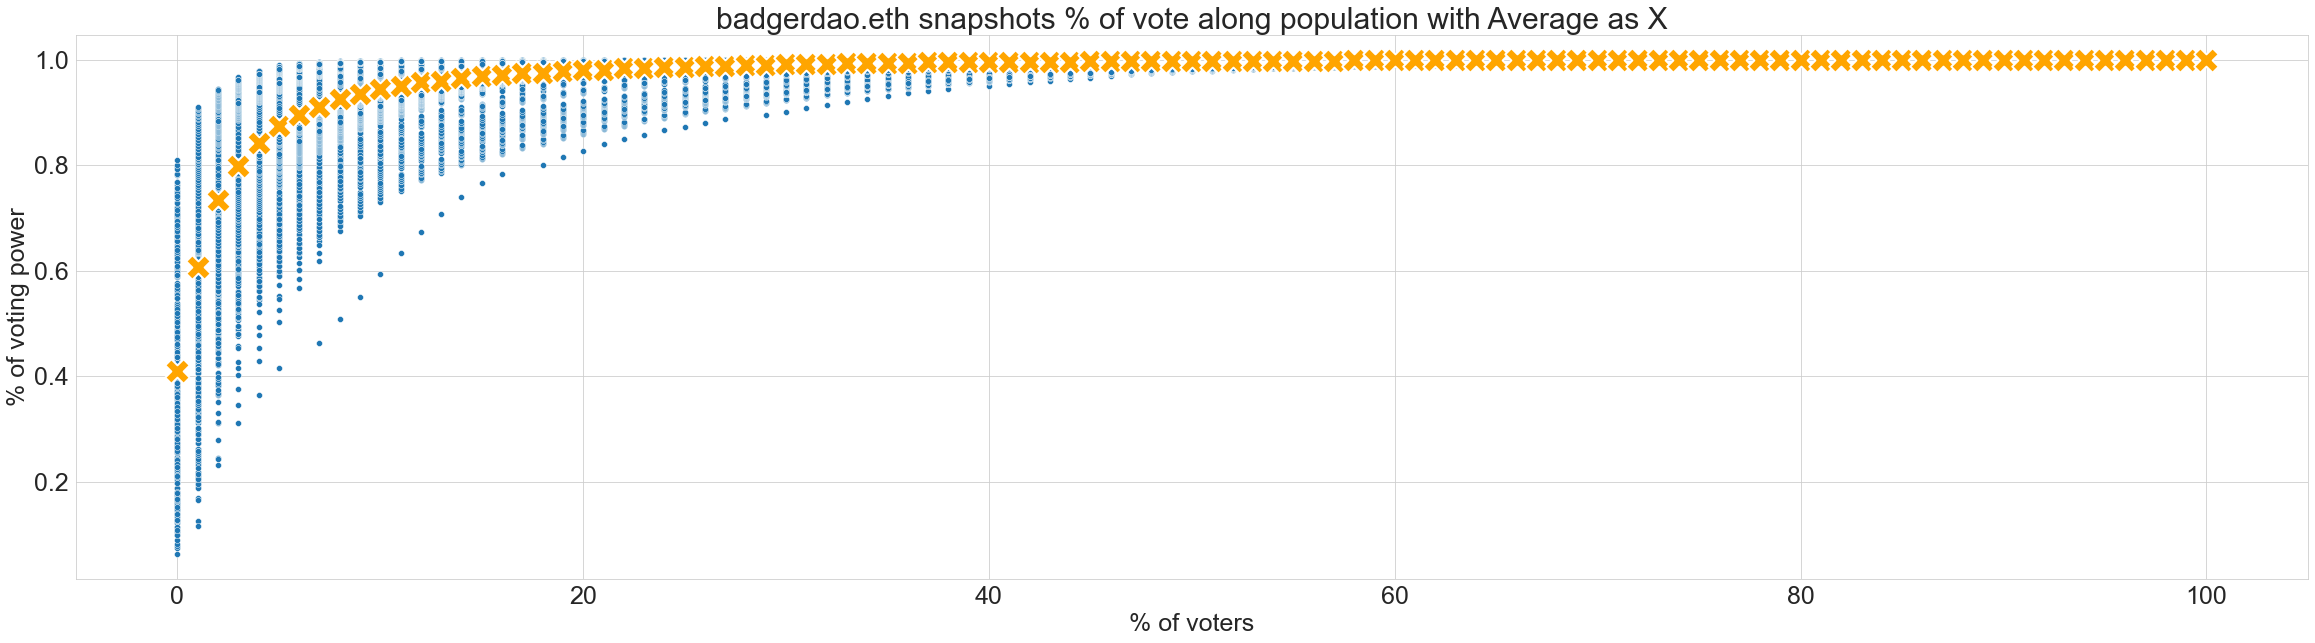

In [192]:
#plt.rc("figure", figsize=(40, 10))
sns.set_style("darkgrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'
sns.set_style("whitegrid")

#ax=sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp", s=500,marker='X',color = 'orange', legend=False)
#sns.lineplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped", hue="Proposal",zorder=-3).set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')#, legend=False)
ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
#and save the chart file, too
plt.savefig(final_file+'\\'+spacename+' vote power distribution.png', dpi=300)

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.

The Orange X shows the average % of power accumulated across all elections.